In [1]:
#CNTK : Basic AutoEncoders(AE) with MNIST Data

#An autoencoder is an artificial neural network used for unsupervised learning of efficient encodings. 
#In other words, they are used for lossy data-specific compression that is learnt automatically instead 
#of relying on human engineered features. The aim of an autoencoder is to learn a representation (encoding) 
#for a set of data, typically for the purpose of dimensionality reduction.

#The autoencoders are very specific to the data-set on hand and are different from standard codecs such as 
#JPEG, MPEG standard based encodings. Once the information is encoded and decoded back to original dimensions 
#some amount of information is lost in the process. Given these encodings are specific to data, autoencoders 
#are not used for compression. However, there are two areas where autoencoders have been found very effective: 
#denoising and dimensionality reduction.

#Autoencoders have attracted attention since they have long been thought to be a potential approach for 
#unsupervised learning. Truly unsupervised approaches involve learning useful representations without 
#the need for labels. Autoencoders fall under self-supervised learning, a specific instance of supervised 
#learning where the targets are generated from the input data.

#GOAL - 
#Our goal is to train an autoencoder that compresses MNIST digits image to a vector of smaller dimension 
#and then restores the image. The MNIST data comprises of hand-written digits with little background noise.

In [2]:
from IPython.display import Image

# Figure 1
Image(url="http://cntk.ai/jup/MNIST-image.jpg", width=300, height=300)

In [3]:
#Import the relevant modules
from __future__ import print_function
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env()
C.cntk_py.set_fixed_random_seed(1)

%matplotlib inline

In [4]:
isFast=True

In [5]:
# Read a CTF formatted text using the CTF deserializer from a file
def create_reader(path, is_training, input_dim, num_label_classes):
    return C.io.MinibatchSource(C.io.CTFDeserializer(path, C.io.StreamDefs(
        labels_viz = C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False),
        features   = C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)
    )), randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

In [6]:
# We search in two locations in the toolkit for the cached MNIST data set.
data_found = False
for data_dir in [os.path.join("..", "Examples", "Image", "DataSets", "MNIST"),
                 os.path.join("data", "MNIST")]:
    train_file = os.path.join(data_dir, "Train-28x28_cntk_text.txt")
    test_file = os.path.join(data_dir, "Test-28x28_cntk_text.txt")
    if os.path.isfile(train_file) and os.path.isfile(test_file):
        data_found = True
        break

if not data_found:
    raise ValueError("Please generate the data by completing CNTK 103 Part A")
print("Data directory is {0}".format(data_dir))

Data directory is data\MNIST


In [7]:
#Model Creation -- Simple AE
# Figure 2
Image(url="http://cntk.ai/jup/SimpleAEfig.jpg", width=200, height=200)

In [8]:
input_dim=784
encoding_dim=32
output_dim=input_dim

def create_model(features):
    with C.layers.default_options(init=C.glorot_uniform()):
        #We scale the input pixel to 0-1 range
        encode=C.layers.Dense(encoding_dim, activation=C.relu)(features/255.0)
        decode=C.layers.Dense(input_dim, activation=C.sigmoid)(encode)
        
    return decode
    

In [9]:
#Train and Test the model

def train_and_test(reader_train, reader_test, model_func):
    
    ###########################
    #Training Model
    ###########################
    
    #Instantiate the input and label variables
    input=C.input_variable(input_dim)
    label=C.input_variable(input_dim)
    
    #Create the model func
    model=model_func(input)
    
    #The labels for this network is same as the MNIST image
    #Note: Inside the model we are scaling the input to 0-1 range
    #Hence we rescale the label to the same range
    #Will show how to use custom loss function
    #loss = -(y*log(p) + (1-y)*log(1-p)) where p= model output and y= target
    #We have normalized the input between 0-1. We are scaling the target to same range
    
    target=label/255.0
    loss=-(target*C.log(model) + (1-target)*C.log(1-model))
    label_error=C.classification_error(model, target)
    
    #training config
    epoch_size=30000 #It is half the dataset size
    minibatch_size=64
    num_sweeps_to_train_with=5 if isFast else 100
    num_samples_per_sweep= 60000
    num_minibatches_to_train= (num_samples_per_sweep*num_sweeps_to_train_with)//minibatch_size
    
    #Instantiate the  trainer object to drive teh model training
    lr_per_sample = [0.00003]
    lr_schedule = C.learning_parameter_schedule_per_sample(lr_per_sample, epoch_size)
    
    #Momentum which is applied on every minibatch size = 64 samples
    momentum_schedule=C.momentum_schedule(0.9126265014311797, minibatch_size)
    
    #We are using a variant of Adam optimizer which is known to work well on this dataset
    learner= C.fsadagrad(model.parameters, lr=lr_schedule, momentum=momentum_schedule)
    
    #Instantiate the trainer
    progress_printer=C.logging.ProgressPrinter(0)
    trainer=C.Trainer(model, (loss, label_error), learner, progress_printer)
    
    #Map the data streams to the input and labels
    #Note: For AutoEncoders, input=label
    input_map={
        input : reader_train.streams.features,
        label : reader_train.streams.features
    }
    
    aggregate_metric=0
    for i in range (num_minibatches_to_train):
        #Read a minibatch from the training data file
        data=reader_train.next_minibatch(minibatch_size, input_map= input_map)
        
        #Run the trainer on and perform model training
        trainer.train_minibatch(data)
        samples=trainer.previous_minibatch_sample_count
        aggregate_metric+= trainer.previous_minibatch_evaluation_average*samples
        
    train_error=(aggregate_metric*100.0)/(trainer.total_number_of_samples_seen)
    print("Average Training Error: {0:0.2f}%".format(train_error))
    
    ##############################################################################
    #Testing the model
    #Note: We use a test file reader to read data different from a training data
    ##############################################################################
    
    #Test data for trained model
    test_minibatch_size=32
    num_samples=10000
    num_minibatches_to_test=num_samples/test_minibatch_size
    test_result = 0.0
    
    #Test error metric calculation
    metric_numer=0
    metric_denom=0
    
    test_input_map= {
        input : reader_test.streams.features,
        label : reader_test.streams.features
    }
    
    for i in range (0, int(num_minibatches_to_test)):
        
        #We are loading the test data in batches specified by the test_minibatch_size
        #Each data point in a minibatch is a MNIST image of 784 dimensions
        #with one pixel per dimension taht will encode/ decode with the trained model
        
        data = reader_test.next_minibatch(test_minibatch_size, input_map=test_input_map)
        
        #Specifying the  mapping of input variables in the model to the actual minibatch data to be tested with
        eval_error=trainer.test_minibatch(data)
        
        #minibatch data to be trained with
        metric_numer+=np.abs(eval_error*test_minibatch_size)
        metric_denom+=test_minibatch_size
        
    #Average of evaluation errors  of all test minibatches
    test_error= (metric_numer*100.0)/ (metric_denom)
    print("Average test error: {0:0.2f}%".format(test_error))
    
    return model, train_error, test_error


In [10]:
num_label_classes=10
reader_train=create_reader(train_file, True, input_dim, num_label_classes)
reader_test=create_reader(test_file, False, input_dim, num_label_classes)
model, simple_ae_train_error, simple_ae_test_error= train_and_test(reader_train, reader_test, model_func=create_model)

C:\ProgramData\Anaconda3\lib\site-packages\cntk\learners\__init__.py:340: RuntimeWarning: When providing the schedule as a number, epoch_size is ignored
  warnings.warn('When providing the schedule as a number, epoch_size is ignored', RuntimeWarning)


 average      since    average      since      examples
    loss       last     metric       last              
 ------------------------------------------------------
Learning rate per 1 samples: 3e-05
      544        544      0.877      0.877            64
      544        544      0.866       0.86           192
      544        543      0.869      0.871           448
      542        541      0.869      0.868           960
      538        533       0.84      0.813          1984
      496        455      0.731      0.625          4032
      385        276      0.566      0.404          8128
      303        221       0.44      0.315         16320
      250        197      0.341      0.242         32704
      208        167      0.258      0.175         65472
      173        138      0.183      0.107        131008
      142        110      0.116     0.0495        262080
Average Training Error: 10.57%
Average test error: 3.04%


In [11]:
#Visualize simple AE results

#Read some data to run the evaluation
num_label_classes=10
reader_eval= create_reader(test_file, False, input_dim, num_label_classes)

eval_minibatch_size=50
eval_input_map = { input : reader_eval.streams.features}

eval_data=reader_eval.next_minibatch(eval_minibatch_size, input_map=eval_input_map)

img_data= eval_data[input].asarray()

#select a random image
np.random.seed(0)
idx=np.random.choice(eval_minibatch_size)

orig_image= img_data[idx, :,:]
decoded_image= model.eval(orig_image)[0]*255

#Print image statistics
def print_img_stats(img, text):
    print(text)
    print("Max: {0:.2f}, Median: {1:.2f}, Mean: {2:.2f}, Min: {3:.2f}".format(np.max(img), np.median(img),
                                                                             np.mean(img), np.min(img)))
    
#print original image
print_img_stats(orig_image, "Original Image Statistics: ")

#print decoded image
print_img_stats(decoded_image, "Decoded Image Statistics: ")



Original Image Statistics: 
Max: 255.00, Median: 0.00, Mean: 24.07, Min: 0.00
Decoded Image Statistics: 
Max: 251.79, Median: 0.43, Mean: 26.11, Min: 0.00


In [12]:
#Plot the original and decoded image

#Define a helper function to plot the images
def plot_image_pair(img1, text1, img2, text2):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6,6))
    
    axes[0].imshow(img1, cmap="gray")
    axes[0].set_title(text1)
    axes[0].axis("off")
    
    axes[1].imshow(img2, cmap="gray")
    axes[1].set_title(text2)
    axes[1].axis("off")

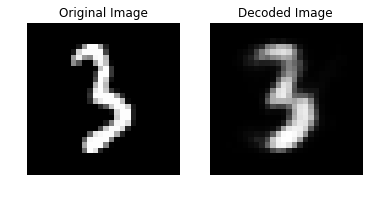

In [13]:
img1= orig_image.reshape(28,28)
text1="Original Image"

img2=decoded_image.reshape(28,28)
text2="Decoded Image"

plot_image_pair(img1, text1, img2, text2)

In [14]:
#Model Creation -- Deep AE

# Figure 3
Image(url="http://cntk.ai/jup/DeepAEfig.jpg", width=500, height=300)

In [15]:
input_dim=784
encoding_dims=[128, 64, 32]
decoding_dims=[64, 128]

encoded_model= None

def create_deep_model(features):
    with C.layers.default_options(init= C.layers.glorot_uniform()):
        encode= C.element_times(C.constant(1.0/255.0), features)
        
        for encoding_dim in encoding_dims:
            encode= C.layers.Dense(encoding_dim, activation=C.relu)(encode)
            
        global encoded_model
        encoded_model= encode
        
        decode=encode
        for decoding_dim in decoding_dims:
            decode = C.layers.Dense(decoding_dim, activation=C.relu)(decode)
            
        decode = C.layers.Dense(input_dim, activation=C.sigmoid)(decode)
        
        return decode
    

In [16]:
num_label_classes = 10
reader_train = create_reader(train_file, True, input_dim, num_label_classes)
reader_test = create_reader(test_file, False, input_dim, num_label_classes)

model, deep_ae_train_error, deep_ae_test_error = train_and_test(reader_train,
                                                                reader_test,
                                                                model_func = create_deep_model)

C:\ProgramData\Anaconda3\lib\site-packages\cntk\learners\__init__.py:340: RuntimeWarning: When providing the schedule as a number, epoch_size is ignored
  warnings.warn('When providing the schedule as a number, epoch_size is ignored', RuntimeWarning)


 average      since    average      since      examples
    loss       last     metric       last              
 ------------------------------------------------------
Learning rate per 1 samples: 3e-05
      544        544       0.75       0.75            64
      544        544      0.771      0.781           192
      544        543       0.78      0.786           448
      543        542      0.789      0.797           960
      530        518      0.863      0.933          1984
      415        303       0.77      0.679          4032
      315        216      0.624       0.48          8128
      258        203        0.5      0.376         16320
      215        171      0.367      0.234         32704
      176        137      0.251      0.136         65472
      145        114      0.165     0.0791        131008
      122       98.7      0.107     0.0483        262080
Average Training Error: 9.80%
Average test error: 3.17%


In [17]:
#Visualize Deep AE results

#Run the same image as the simple autoencoder through the deep encoder
orig_image= img_data[idx, :, :]
decoded_image=model.eval(orig_image)[0]*255

#Print image statistics
def print_img_stats(img, text):
    print(text)
    print("Max: {0:.2f}, Median: {1:.2f}, Mean: {2:.2f}, Min: {3:.2f}".format(np.max(img), np.median(img),
                                                                             np.mean(img), np.min(img)))
    
#print original image
print_img_stats(orig_image, "Original Image Statistics: ")

#print decoded image
print_img_stats(decoded_image, "Decoded Image Statistics: ")


Original Image Statistics: 
Max: 255.00, Median: 0.00, Mean: 24.07, Min: 0.00
Decoded Image Statistics: 
Max: 249.46, Median: 0.03, Mean: 23.85, Min: 0.00


In [18]:
#Plot the original and decoded image

#Define a helper function to plot the images
def plot_image_pair(img1, text1, img2, text2):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6,6))
    
    axes[0].imshow(img1, cmap="gray")
    axes[0].set_title(text1)
    axes[0].axis("off")
    
    axes[1].imshow(img2, cmap="gray")
    axes[1].set_title(text2)
    axes[1].axis("off")

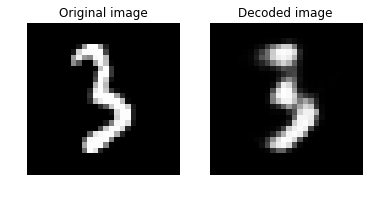

In [19]:
# Plot the original and the decoded image
img1 = orig_image.reshape(28,28)
text1 = 'Original image'

img2 = decoded_image.reshape(28,28)
text2 = 'Decoded image'

plot_image_pair(img1, text1, img2, text2)

In [24]:
#we will explore how we can compare one to another and also show how to extract an encoded input for a given input. 
#For visualizing high dimension data in 2D, t-SNE (t-distributed Stochastic Neighbor Embedding) 
#is probably one of the best methods. However, it typically requires relatively low-dimensional data. 
#So a good strategy for visualizing similarity relationships in high-dimensional data is to encode data into 
#a low-dimensional space (e.g. 32 dimensional) using an autoencoder first, extract the encoding of the input 
#data followed by using t-SNE for mapping the compressed data to a 2D plane.

#We will use the deep autoencoder outputs to: - Compare two images and - Show how we can retrieve an encoded (compressed) data.

#t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities 
#and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding 
#and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we 
#can get different results.

#Read some data to get the image data and corresponding labels
num_label_classes=10
reader_viz=create_reader(test_file, False, input_dim, num_label_classes)

image=  C.input_variable(input_dim)
image_label = C.input_variable(num_label_classes)

viz_minibatch_size=50

viz_input_map={
    image : reader_viz.streams.features,
    image_label : reader_viz.streams.labels_viz
}

viz_data=reader_eval.next_minibatch(viz_minibatch_size, input_map=viz_input_map)

img_data= viz_data[image].asarray()
imglabel_raw= viz_data[image_label].asarray()

In [25]:
#Map the image labels into indices in the minibatch array
img_labels= [np.argmax(imglabel_raw[i,:,:]) for i in range(0, imglabel_raw.shape[0])]

from collections import defaultdict
label_dict= defaultdict(list)
for img_idx, img_label in enumerate(img_labels):
    label_dict[img_label].append(img_idx)
    
#Print indices corresponding to 3 digits
randIdx = [1,3,9]
for i in randIdx:
    print("{0}: {1}".format(i, label_dict[i]))

1: [7, 35, 37, 43, 45]
3: [12, 42]
9: [4, 5, 8, 13, 18, 25]


In [26]:
#We will compute cosine distance between two images using scipy

from scipy import spatial

def image_pair_cosine_distance(img1, img2):
    if img1.size!=img2.size:
        raise ValueEerror("Two images need to be of same dimension")
    return 1-spatial.distance.cosine(img1, img2)
    

Distance between two original image: 0.534
Distance between two decoded image: 0.723


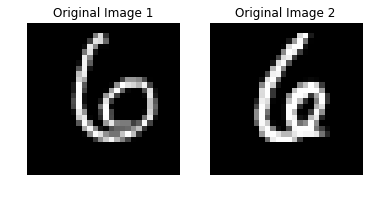

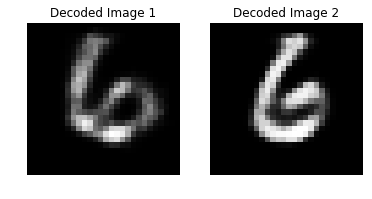

In [27]:
#Lets compute the distance between the two images of same number

digit_of_interest=6

digit_index_list= label_dict[digit_of_interest]

if len(digit_index_list)<2:
    print("Need atleast two images to compare")
else:
    imgA = img_data[digit_index_list[0],:,:][0]
    imgB = img_data[digit_index_list[1],:,:][0]
    
    #print distance between original image
    imgA_B_dist= image_pair_cosine_distance(imgA, imgB)
    print("Distance between two original image: {0:.3f}".format(imgA_B_dist))
    
    #Plot the two images
    img1=imgA.reshape(28,28)
    text1='Original Image 1'
    
    img2=imgB.reshape(28,28)
    text2='Original Image 2'
    
    plot_image_pair(img1, text1, img2, text2)
    
    #Decode the encoded stream
    imgA_decoded= model.eval([imgA])[0]
    imgB_decoded= model.eval([imgB])[0]
    imgA_B_decoded_list = image_pair_cosine_distance(imgA_decoded, imgB_decoded)
    
    #Print the distance between decoded image 
    print("Distance between two decoded image: {0:.3f}".format(imgA_B_decoded_list))
    
    #Plot the two images
    #Plot the original and decoded image
    img1=imgA_decoded.reshape(28,28)
    text1='Decoded Image 1'
    
    img2=imgB_decoded.reshape(28,28)
    text2='Decoded Image 2'
    
    plot_image_pair(img1, text1, img2, text2)

In [28]:
#Note: The cosine distance between the original images comparable to the distance between the corresponding decoded images. 
#A value of 1 indicates high similarity between the images and 0 indicates no similarity.

In [29]:
#Simple auto encoder test error
print(simple_ae_test_error)

3.0350858990389566


In [30]:
#Deep auto encoder test error
print(deep_ae_test_error)

3.1667083137644787
